### Run imports

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import cvxpy as cp

from battery_energy_trader.data_handler import DataHandler
from battery_energy_trader.optimizer import Optimizer

%reload_ext autoreload
%autoreload 2

### Data loading and preprocessing

In [124]:
# Path to the csv data file
file_path = 'data/Day-ahead_Prices_60min.csv'

# Initialize the data handler and load the data
data_handler = DataHandler(file_path, freq=60)

### Brief Data Analysis

Plot averaged daily prices to see pattern over weeks.

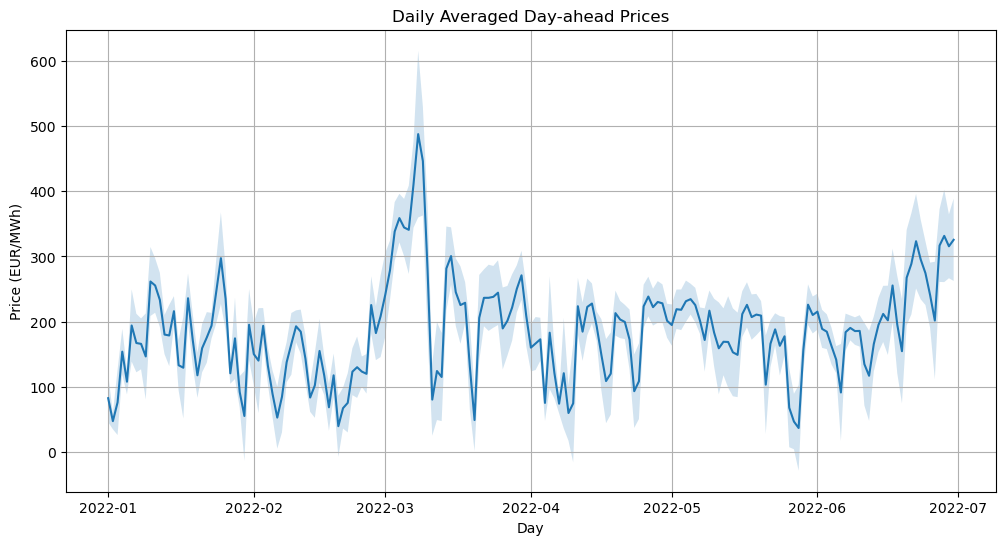

In [125]:
data_handler.plot_price_daily_averaged(plot_variance=True)

Plot hourly prices averaged over the whole dataset

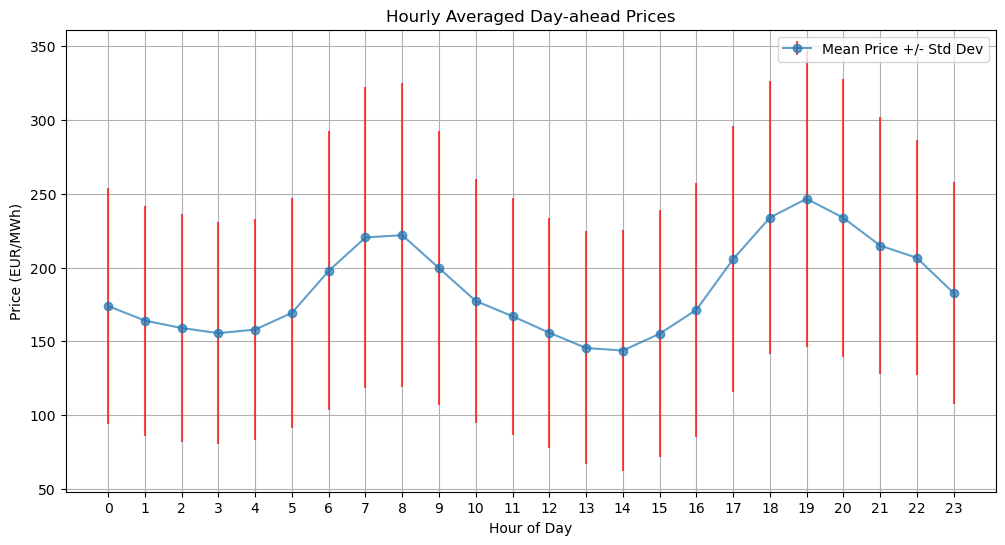

In [126]:
data_handler.plot_hourly_price_averaged(plot_variance=True) 

We see the hours of the day have a clear influence on the prices. We can probably exploit this to predict future prices.

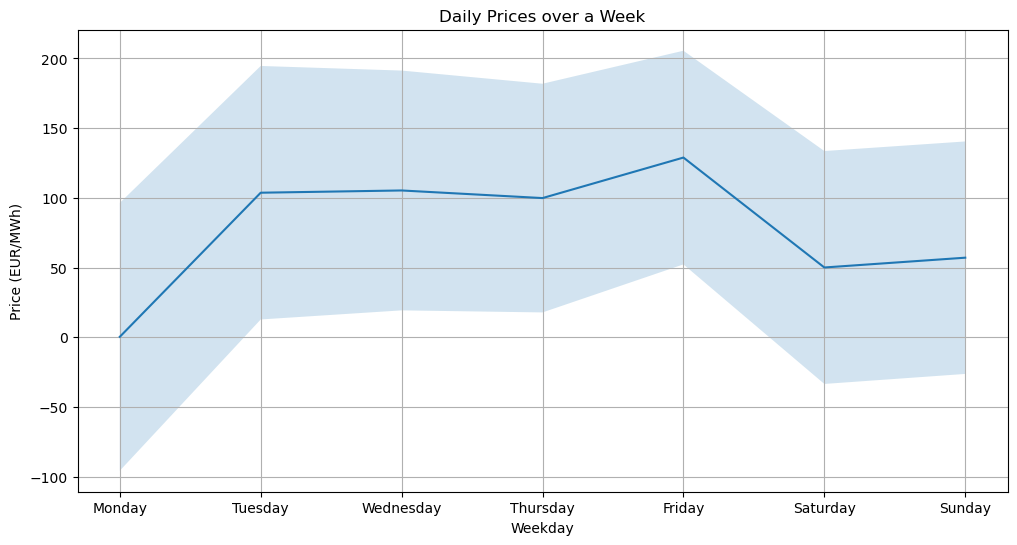

In [127]:
data_handler.plot_daily_price_over_week(plot_variance=True)

#### Feature Engineering

In [128]:
# Feature Engineering
data_handler.data['Hour of Day'] = data_handler.data['Start Time'].dt.hour
data_handler.data['Weekday'] = data_handler.data['Start Time'].dt.dayofweek
#data_handler.data['Week'] = data_handler.data['Start Time'].dt.isocalendar().week

#### Data Split

In [147]:

# Splitting the data into train (60%), validation (20%), and test (20%) sets -> Important to keep the time order
train_size = int(len(data_handler.data) * 0.6)
val_size = int(len(data_handler.data) * 0.2)
train_df, val_df, test_df = data_handler.data[:train_size].reset_index(drop=True), data_handler.data[train_size:train_size+val_size].reset_index(drop=True), data_handler.data[train_size+val_size:].reset_index(drop=True)  

In [148]:
# print the sizes of the data sets

# print total size
print(f"Total size: {len(data_handler.data)}")

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Total size: 4344
Train size: 2606
Validation size: 868
Test size: 870


It should be investigated if normalizing is boosting performance. i.e. z-score or minmax normalization

In [131]:
# Z-score normalization
# Normalize the price column
# mean_price = train_df['Day-ahead Price [EUR/MWh]'].mean()
# std_price = train_df['Day-ahead Price [EUR/MWh]'].std()

# train_df['Day-ahead Price [EUR/MWh]'] = (train_df['Day-ahead Price [EUR/MWh]'] - mean_price) / std_price
# val_df['Day-ahead Price [EUR/MWh]'] = (val_df['Day-ahead Price [EUR/MWh]'] - mean_price) / std_price
# test_df['Day-ahead Price [EUR/MWh]'] = (test_df['Day-ahead Price [EUR/MWh]'] - mean_price) / std_price

# LSTM approach
We can try to learn predicting the prices with neural networks, capabale of learning TS data, i.e. LSTMs

Later on we can also explore more sophisticated models like transformer based architectures.


#### Overfitting atempt
For the beginning we want to overfit on a minibatch (48 hours) -> 1 training sample (24h historical window + 24h prediction window)

In [149]:
train_df = train_df[:480]

#### Dataset Class

In [150]:

class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, input_window=24, output_window=24):
        self.input_window = input_window
        self.output_window = output_window
        
        # We will only use starting points where 'Hour of Day' == 0 and then predict the next x hours (x=output_window)
        # Filter to include only rows where 'Hour of Day' == 0 for starting points
        starting_points = dataframe[dataframe['Hour of Day'] == 0].index
        
        # Ensure we have enough data for input_window + output_window for each starting point
        self.valid_starts = [idx for idx in starting_points if idx + input_window + output_window - 1 < len(dataframe)]
        
        self.features = dataframe[['Day-ahead Price [EUR/MWh]']]#, 'Hour of Day', 'Weekday']] # Select features
        
        self.labels = dataframe['Day-ahead Price [EUR/MWh]']
        
    def __len__(self):
        return len(self.valid_starts)
    
    def __getitem__(self, idx):
        start_idx = self.valid_starts[idx]
        end_idx = start_idx + self.input_window
        
        x = self.features.iloc[start_idx:end_idx].values
        y = self.labels.iloc[end_idx:end_idx+self.output_window].values
        
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

# class TimeSeriesDataset(Dataset):
#     def __init__(self, dataframe, input_window=24, output_window=24):
#         self.dataframe = dataframe
#         self.input_window = input_window
#         self.output_window = output_window
        
#         self.features = self.dataframe[['Day-ahead Price [EUR/MWh]', 'Hour of Day', 'Weekday']]  # Select features
#         self.labels = self.dataframe['Day-ahead Price [EUR/MWh]']  # Target
        
#     def __len__(self):
#         return len(self.dataframe) - self.input_window - self.output_window + 1
    
#     def __getitem__(self, idx):
#         x = self.features.iloc[idx:idx+self.input_window].values
#         y = self.labels.iloc[idx+self.input_window:idx+self.input_window+self.output_window].values
#         return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)


#### Create Datasets

In [151]:
# Create datasets
input_window = 24 # provide 24 hours (1 day) of historical data as input
output_window = 24 # predict the next 24 hours

train_dataset = TimeSeriesDataset(train_df, input_window, output_window)
val_dataset = TimeSeriesDataset(val_df, input_window, output_window)
test_dataset = TimeSeriesDataset(test_df, input_window, output_window)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [152]:
len(train_dataset), len(val_dataset), len(test_dataset)

(19, 34, 35)

#### Define simple LSTM model

TODOs: Investigate different loss func.

In [153]:
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_layer_size=100, num_layers=1, output_size=24):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :]) # We only want the last value from the sequence
        return predictions
    
    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        predictions = self.forward(sequences)
        loss = nn.MSELoss()(predictions, labels)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        predictions = self.forward(sequences)
        loss = nn.MSELoss()(predictions, labels)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


#### Create Model

In [154]:
input_size = train_dataset[0][0].shape[1]
model = LSTMModel(input_size=input_size,  hidden_layer_size=50, num_layers=2, output_size=24)

#### Train model

In [163]:

# early_stop_callback = EarlyStopping(
#    monitor='val_loss',
#    min_delta=0.00,
#    patience=20,
#    verbose=True,5
#    mode='min'
# )

# Specify the directory to save TensorBoard logs
logger = TensorBoardLogger("tensorboard")

trainer = Trainer(max_epochs=4000, logger=logger) # ,callbacks=[early_stop_callback]
trainer.fit(model, train_loader,val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 31.0 K
1 | linear | Linear | 1.2 K 
----------------------------------
32.2 K    Trainable params
0         Non-trainable params
32.2 K    Total params
0.129     Total estimated model params size (MB)


/Users/matthiaskiller/miniforge3/envs/entrix_case_study_matthias_3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/matthiaskiller/miniforge3/envs/entrix_case_study_matthias_3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/matthiaskiller/miniforge3/envs/entrix_case_study_matthias_3/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want

Epoch 3999: 100%|██████████| 1/1 [00:00<00:00, 42.73it/s, v_num=70] 

`Trainer.fit` stopped: `max_epochs=4000` reached.


Epoch 3999: 100%|██████████| 1/1 [00:00<00:00, 30.98it/s, v_num=70]


#### Evaluate

In [139]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():  # No need to track gradients
        for x_batch, y_batch in data_loader:
            y_pred = model(x_batch).numpy()  # Predict
            predictions.append(y_pred)
            actuals.append(y_batch.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}, actuals, predictions



We now evaluate only on the train sample and check if we sucessfully overfitted on this one sample.

In [164]:
metrics, actuals , predictions = evaluate_model(model, train_loader)
print(metrics)

{'MAE': 53.773365, 'MSE': 4005.1702, 'RMSE': 63.286415, 'R2': 0.04989593841827581}


#### Plot predicted vs. true for one sample

In [165]:
# Plot the actual vs predicted prices for a given day
def plot_predictions(actuals, predictions, day):
    plt.figure(figsize=(10, 6))
    plt.plot(actuals[day], label='Actual Prices', color='blue')
    plt.plot(predictions[day], label='Predicted Prices', color='red', alpha=0.7)
    plt.title('Actual vs Predicted Electricity Prices')
    plt.xlabel('Hour')
    plt.ylabel('Price [EUR/MWh]')
    plt.legend()
    plt.show()

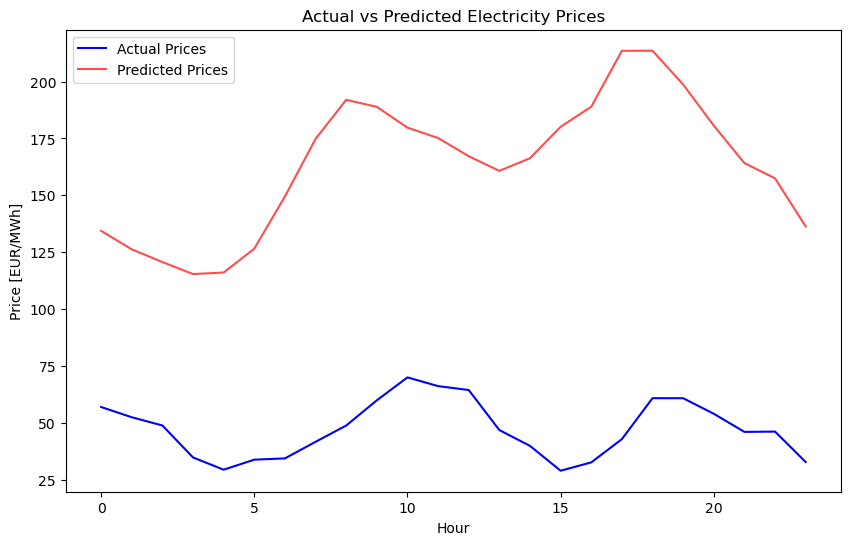

In [166]:
plot_predictions(actuals, predictions, 0)

Our model is able to perfectly fit the train sample. Lets now check performance on the val set.

{'MAE': 145.43568, 'MSE': 23818.932, 'RMSE': 154.33383, 'R2': -18.303166113313885}


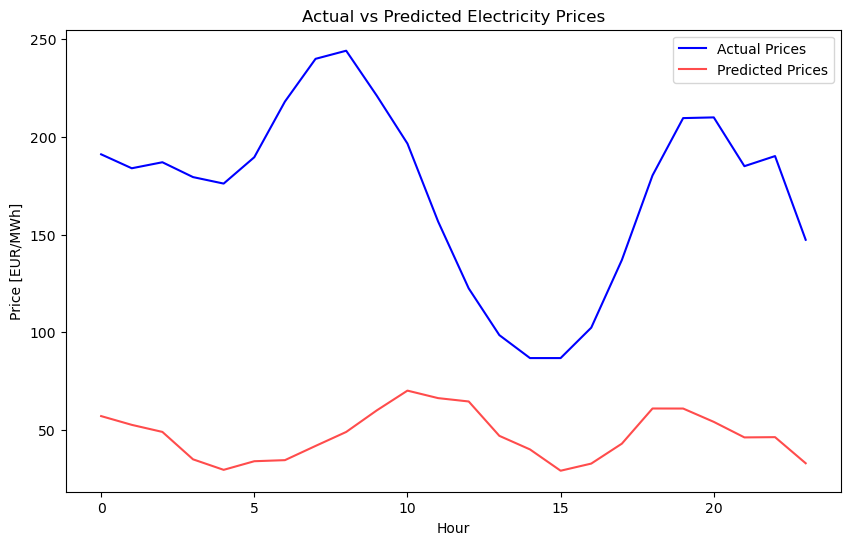

In [118]:
metrics, actuals , predictions = evaluate_model(model, val_loader)
print(metrics)
plot_predictions(actuals, predictions, 1)

We see that we perform badly on the val set and cleary overfit on the train set.
This indicates, that we have at least some basic learning in place.
We would now scale the training set and try to overfit on the complete training set. If possible we would then try to reguralize the model to achieve good generalization.

**I will not show this here as training and finding the right parameters might take some time.**

Instead we will fall back for now to a simpler statistical model. In future work we might also explore more fancy TS models and frameworks i.e. using https://ts.gluon.ai/stable/index.html 



# SARIMAX Approach

Lets try the SARIMAX model which is often used for TS data and for price predictions i.e.: https://ieeexplore.ieee.org/document/9002930
We first split our data in three sets.

#### Data Split

We split the data again in train, validation and test. -> validation could be used to tune the hyperparams which is left for future work. -> could be either done with more statistical insights or i.e. grid search

In [10]:
# Assuming df is your DataFrame and it's sorted by 'Start Time'
prices = data_handler.data['Day-ahead Price [EUR/MWh]'].values


# Calculate the indices for splitting the data such that each set is divisible by 24
total_hours = len(prices)
split_train = int(total_hours * 0.6)  # 60% for training
split_train -= split_train % 24  # Make divisible by 24
split_val = int(total_hours * 0.8)  # 20% for validation
split_val -= (split_val - split_train) % 24  # Adjust to be divisible by 24 taking into account the training set

# Split the data
train = prices[:split_train]
val = prices[split_train:split_val]
test = prices[split_val:] # Remaining 20% for testing

In [14]:
train.shape, val.shape, test.shape  

((2592,), (864,), (888,))


We then have to choose the (p, d, q) parameters (autoregressive, differences, moving average components) for our model.

For this we first analyse our autocorrelation plots and partial autocorrelation.

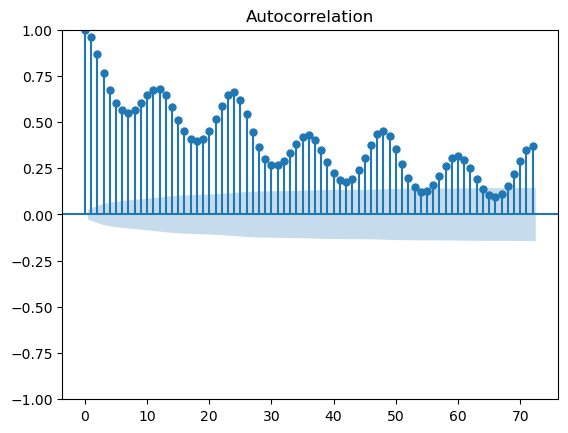

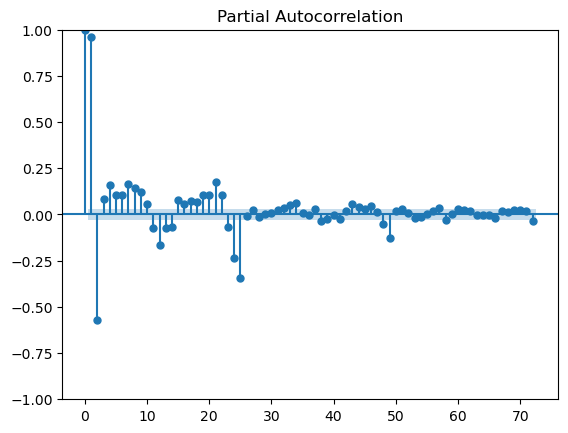

In [119]:
# Check ACF and PACF on the training set
plot_acf(train, lags=72)
plot_pacf(train, lags=72)
plt.show()

We can see clear seasonal (daily) patterns in the acf plot

We also have to test for stationarity, i.e. with an adfuller test. (augmented dickey fuller)

In [13]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.481201
p-value: 0.000002
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


p-value needs to be bwlow 0.05 and ADF stat. below the critical values
-> Evidence against the null hypothesis, the data has no unit root and  hence looks stationary

We can set d = 0 due to the stationarity and p=1 due to the spikes in the beginning and to reduce compute time. The ACF plot does not show a clear cut-off, but rather a gradual decline, but lets start with q = 1 to account for any small MA component.

In [ ]:
train = np.concatenate([train, val])
history = list(train)  # List to append new observations
predictions = []

results_mae = []
results_mse = []
results_rmse = []
results_r2 = []

#test=test[:168]

for t in range(0, len(test), 24):  # Step by 24 hours
    # Define SARIMA model
    model = SARIMAX(history, order=(1,0,1), seasonal_order=(1, 0, 1, 24)) # seasonal order (P, D, Q, s), s is 24 for daily seasonality in hourly data

    # Fit the model
    model_fit = model.fit(disp=False)

    # Forecast the next 24 hours
    output = model_fit.forecast(steps=24) 

    # Append the daily predictions
    predictions.extend(output)

    # Get the current 24 actual observations
    obs = test[t:t+24]

    # Update the history with the actual observations to be included in the next iteration
    history.extend(obs) 
    
    # Calculate metrics
    results_mae.append(mean_absolute_error(test[t:t+24], output))
    results_mse.append(mean_squared_error(test[t:t+24], output))
    results_rmse.append(np.sqrt(mean_squared_error(test[t:t+24], output)))
    results_r2.append(r2_score(test[t:t+24], output))

    print(f'Day {t//24+1} - MAE: {results_mae[-1]}, MSE: {results_mse[-1]}, RMSE: {results_rmse[-1]}, R2: {results_r2[-1]}')

In [16]:
# Calculate the overall metrics averaged over all days
mae = np.mean(results_mae)
mse = np.mean(results_mse)
rmse = np.mean(results_rmse)
r2 = np.mean(results_r2)

print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')

Test MAE: 41.67002056000003
Test MSE: 2956.5704128838684
Test RMSE: 48.662186380719575
Test R2: -0.16982008854797223


In [17]:
# Plot the actual vs predicted prices for a given day
def plot_predictions(actuals, predictions, day):
    
    plt.figure(figsize=(10, 6))
    plt.plot(actuals[day*24:(day+1)*24], label='Actual Prices', color='blue')
    plt.plot(predictions[day*24:(day+1)*24], label='Predicted Prices', color='red', alpha=0.7)
    plt.title('Actual vs Predicted Electricity Prices')
    plt.xlabel('Hour')
    plt.ylabel('Price [EUR/MWh]')
    plt.legend()
    plt.show()

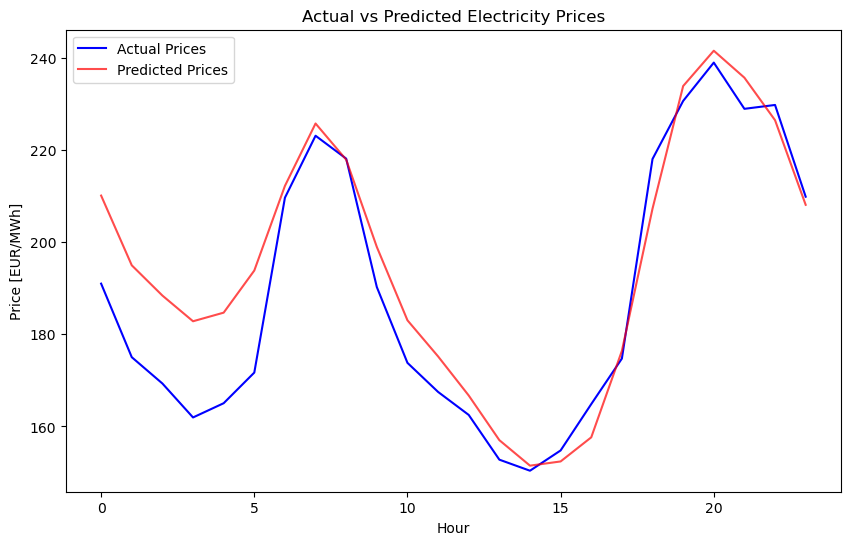

In [18]:
plot_predictions(test,predictions,8)

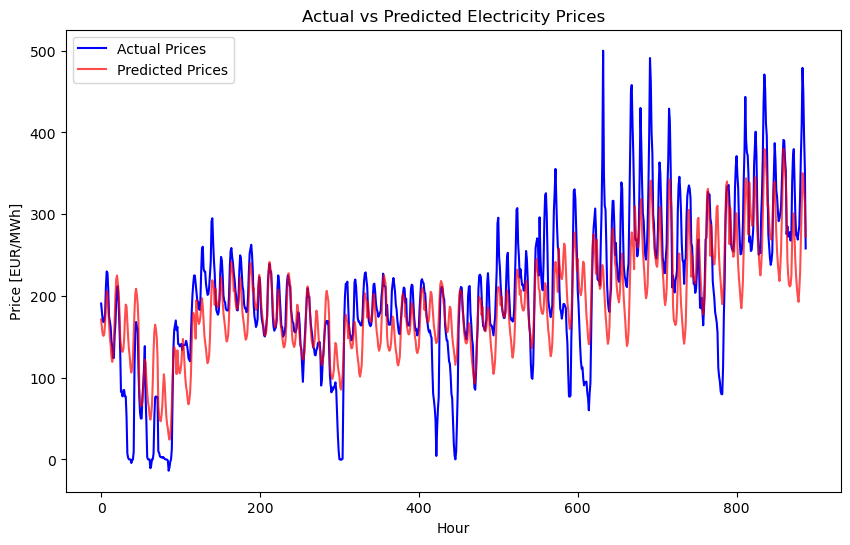

In [19]:
# plot of the actual vs predicted prices for all days

plt.figure(figsize=(10, 6))
plt.plot(test, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Hour')
plt.ylabel('Price [EUR/MWh]')
plt.legend()

# Optimizing on forcasted prices

#### Compare with baseline (known prices)

We now want to compare our optimal controller (known prices) vs our controller on predicted prices. We will evaluate on the test set data only.
To make this happen we Manipulate the data_handler to only hold the test data. **The classes have to be refactored but this is future work.**

((2592,), (864,), (888,)) train, val, test -> index 3456 start of test.


In [27]:
# Path to the csv data file
file_path = 'data/Day-ahead_Prices_60min.csv'

# Initialize the data handler and load the data
data_handler_test = DataHandler(file_path, freq=60)

# Maniuplate the data to only include the test set
data_handler_test.data = data_handler_test.data[3456:]

# reset indices
data_handler_test.data.reset_index(drop=True, inplace=True)

# adjust the total days
data_handler_test.total_days = len(data_handler_test.data) // 24

print(data_handler_test.total_days)

37


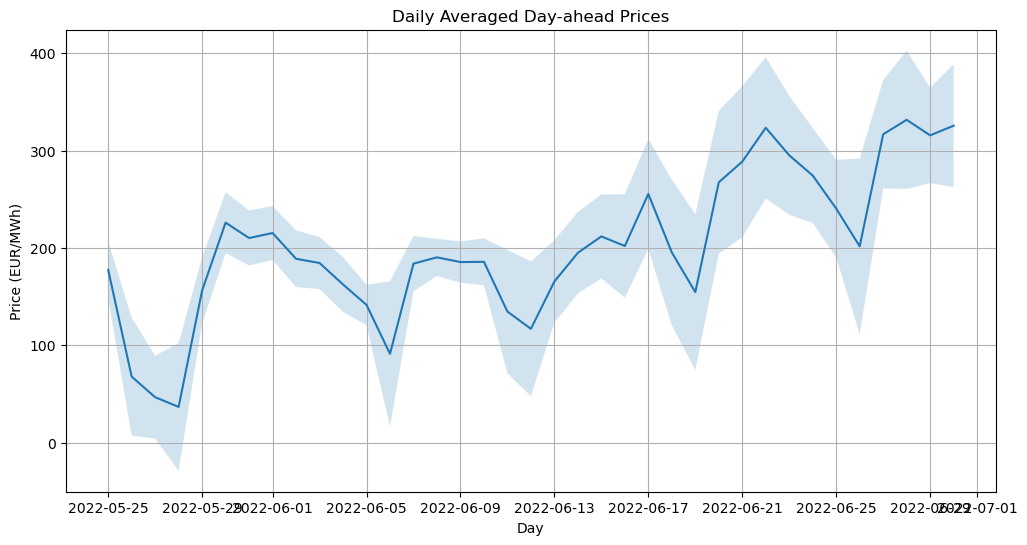

In [122]:
data_handler_test.plot_price_daily_averaged(plot_variance=True)

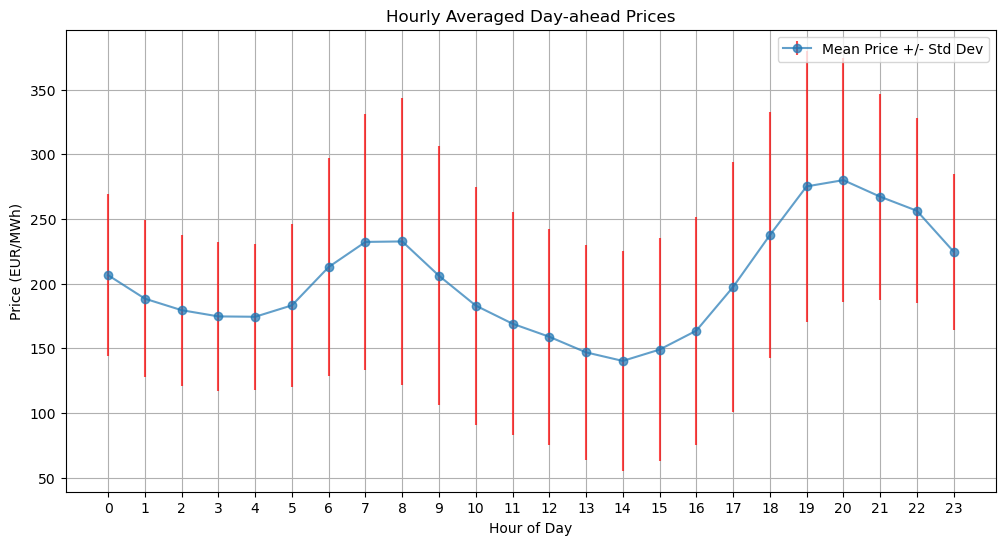

In [30]:
data_handler_test.plot_hourly_price_averaged(plot_variance=True)

### Evaluate on known data (test set)

In [31]:
optimizer = Optimizer(data_handler=data_handler_test, battery_capacity=1,max_power=1,efficiency=1)

In [32]:
optimizer.optimize_milp(time_horizon=1, solver=cp.GLPK_MI,constraints_soc_end=False)

Total profit: 8173.38 EUR


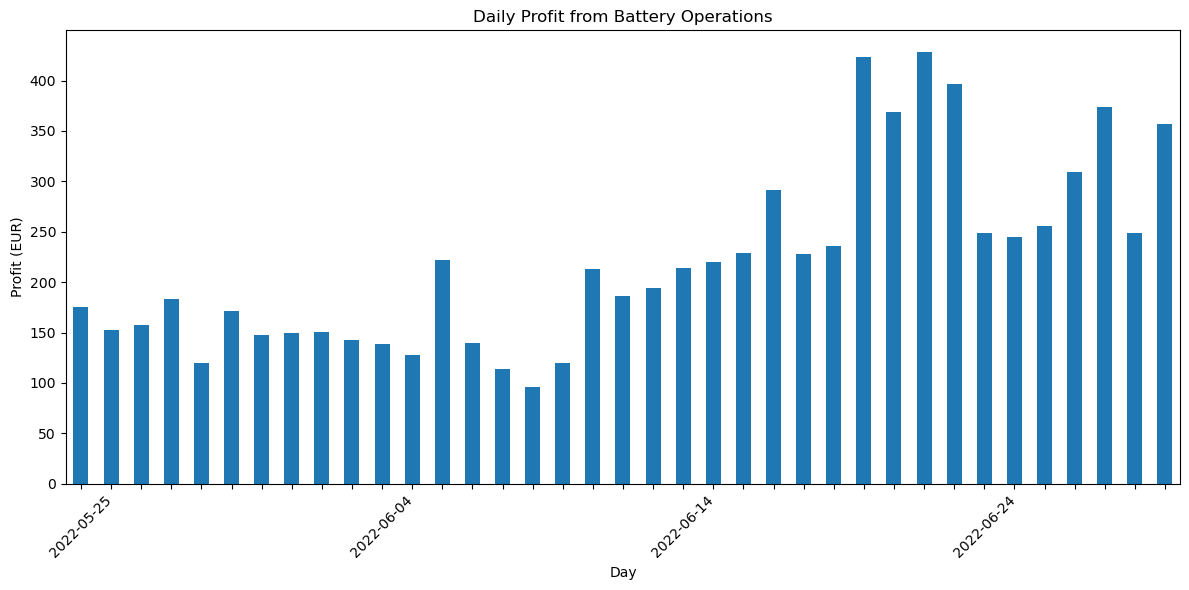

In [33]:
data_handler_test.plot_daily_profit()

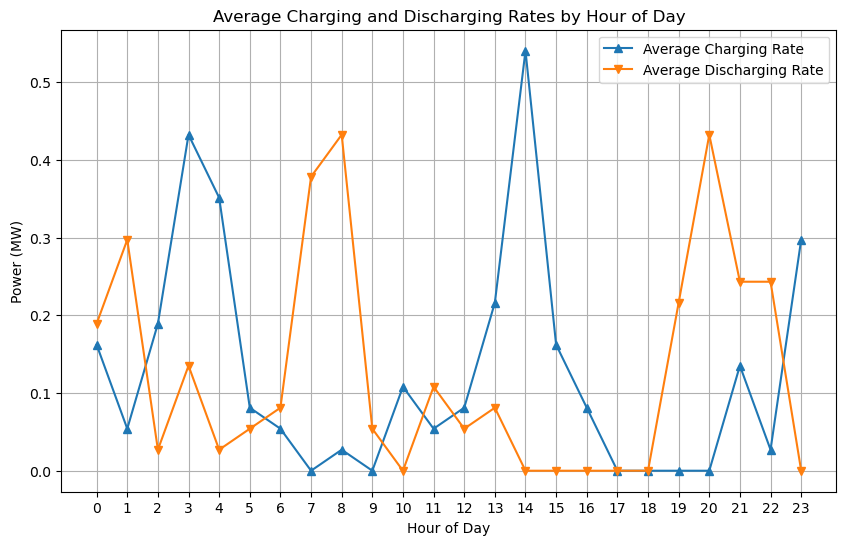

In [34]:
data_handler_test.plot_averaged_charge_discharge_over_day()

### Predicted values

Now with predicted values instead. For this, we will run the SARIMAX model and add the predictions as actual prices to the data_loader.
AGAIN: This needs to be refactored if there would be more time.

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = np.concatenate([train, val])
history = list(train)  # List to append new observations
predictions = []

results_mae = []
results_mse = []
results_rmse = []
results_r2 = []

#test=test[:168]

for t in range(0, len(test), 24):  # Step by 24 hours
    # Define SARIMA model
    model = SARIMAX(history, order=(1,0,1), seasonal_order=(1, 0, 1, 24)) # seasonal order (P, D, Q, s), s is 24 for daily seasonality in hourly data

    # Fit the model
    model_fit = model.fit(disp=False)

    # Forecast the next 24 hours
    output = model_fit.forecast(steps=24) 

    # Append the daily predictions
    predictions.extend(output)

    # Get the current 24 actual observations
    obs = test[t:t+24]

    # Update the history with the actual observations to be included in the next iteration
    history.extend(obs) 
    
    # Calculate metrics
    results_mae.append(mean_absolute_error(test[t:t+24], output))
    results_mse.append(mean_squared_error(test[t:t+24], output))
    results_rmse.append(np.sqrt(mean_squared_error(test[t:t+24], output)))
    results_r2.append(r2_score(test[t:t+24], output))

    print(f'Day {t//24+1} - MAE: {results_mae[-1]}, MSE: {results_mse[-1]}, RMSE: {results_rmse[-1]}, R2: {results_r2[-1]}')

Day 1 - MAE: 18.335520919107452, MSE: 382.81647932639993, RMSE: 19.565696494794146, R2: 0.5404801714933881
Day 2 - MAE: 89.04884074311951, MSE: 9665.498333113794, RMSE: 98.3132663129132, R2: -1.755708030934291
Day 3 - MAE: 59.30202641825435, MSE: 5064.920794870598, RMSE: 71.16825693292338, R2: -1.9162914786944483
Day 4 - MAE: 54.07522079656494, MSE: 3634.546947894407, RMSE: 60.2872038486975, R2: 0.11637442289932232
Day 5 - MAE: 30.22466742360119, MSE: 1090.50472367365, RMSE: 33.02279097341183, R2: 0.005470376838090707
Day 6 - MAE: 54.68223267768989, MSE: 3705.1078195072187, RMSE: 60.86959684035388, R2: -2.9653864517049637
Day 7 - MAE: 26.577146159592175, MSE: 905.3924544540441, RMSE: 30.089740019715094, R2: -0.179432621554505
Day 8 - MAE: 26.45657120333617, MSE: 841.0021909758885, RMSE: 29.000037775421752, R2: -0.1492013494229767
Day 9 - MAE: 8.099530054217672, MSE: 118.28581117421577, RMSE: 10.875928060364126, R2: 0.8547827358499863
Day 10 - MAE: 12.266003426955097, MSE: 215.944735114

In [80]:
# Calculate the overall metrics averaged over all days
mae = np.mean(results_mae)
mse = np.mean(results_mse)
rmse = np.mean(results_rmse)
r2 = np.mean(results_r2)

print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')

Test MAE: 43.23667344714943
Test MSE: 3188.92049209926
Test RMSE: 50.43253091652688
Test R2: -0.25814108419109383


Prepare a data_loader with overwritten prices (predicted) for the test set

In [81]:
# Path to the csv data file
file_path = 'data/Day-ahead_Prices_60min.csv'

# Initialize the data handler and load the data
data_handler_test_forecast = DataHandler(file_path, freq=60)

# Maniuplate the data to only include the test set
data_handler_test_forecast.data = data_handler_test_forecast.data[3456:]

# reset indices
data_handler_test_forecast.data.reset_index(drop=True, inplace=True)

# adjust the total days
data_handler_test_forecast.total_days = len(data_handler_test.data) // 24

print(data_handler_test_forecast.total_days)

37


In [82]:
# Overwrite the day ahead prices with the predicted prices
data_handler_test_forecast.data['Day-ahead Price [EUR/MWh]'] = predictions

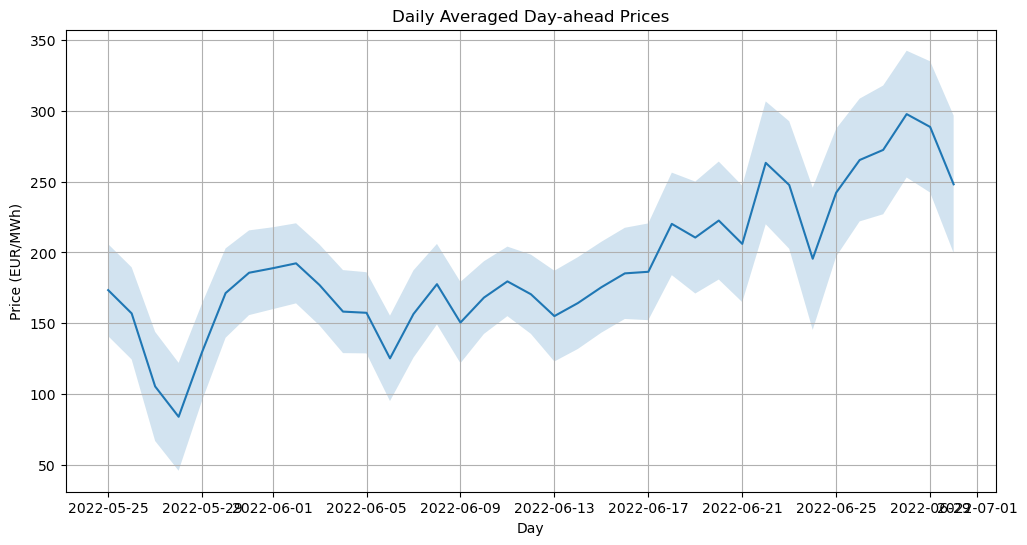

In [83]:
data_handler_test_forecast.plot_price_daily_averaged(plot_variance=True)

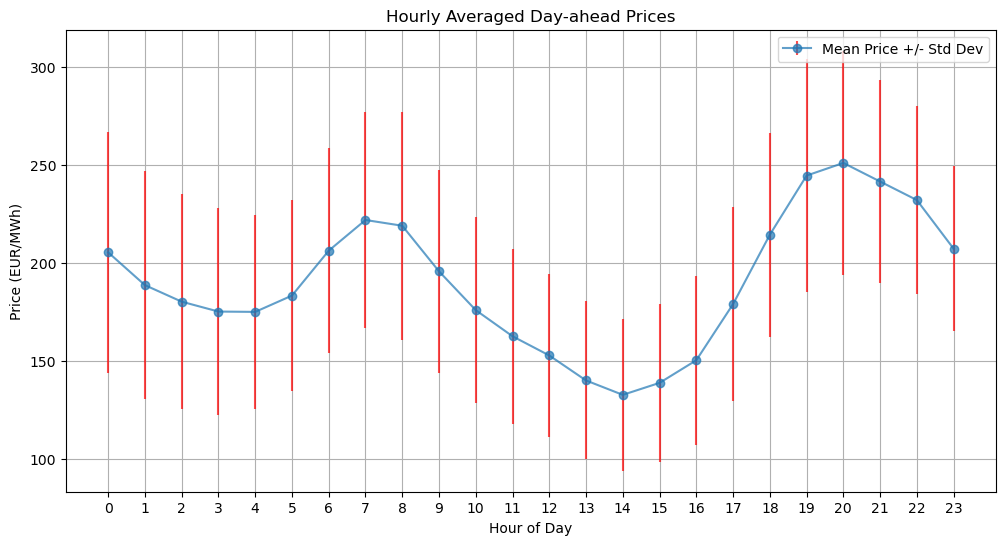

In [84]:
data_handler_test_forecast.plot_hourly_price_averaged(plot_variance=True)

### Run optimization on predicted prices

In [85]:
optimizer_forecast = Optimizer(data_handler=data_handler_test_forecast, battery_capacity=1,max_power=1,efficiency=1)

In [86]:
optimizer_forecast.optimize_milp(time_horizon=1, solver=cp.GLPK_MI,constraints_soc_end=False)

Total profit: 6128.95 EUR


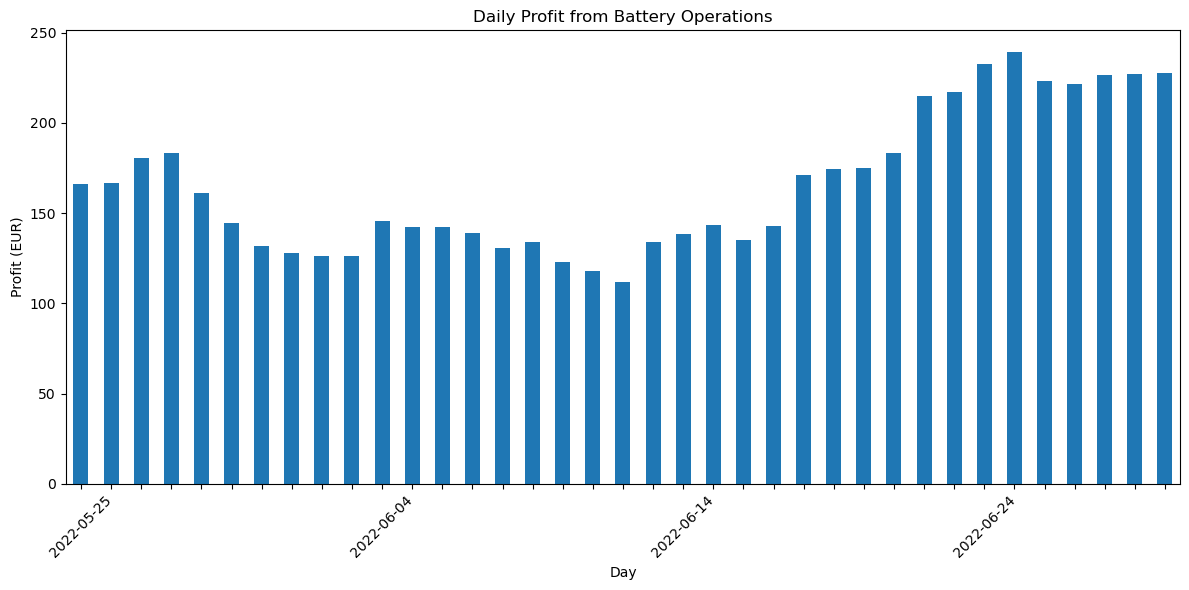

In [87]:
data_handler_test_forecast.plot_daily_profit()

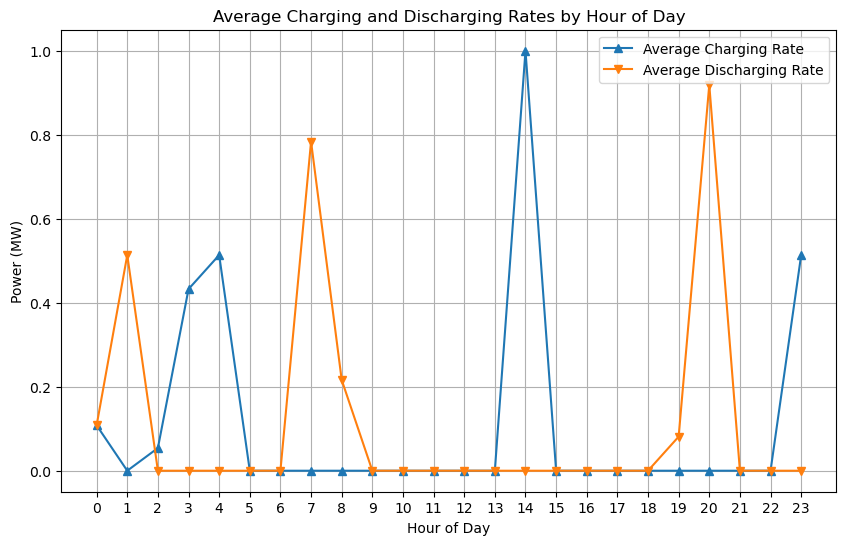

In [88]:
data_handler_test_forecast.plot_averaged_charge_discharge_over_day()

## Analysis

In the test date range we would earn with known prices a total profit of 8173.38 EUR. 
With predicted prices: **6128.95 EUR -> 75% of the maximum possible. **
With a more sophisticated forecasting approach this will most likely improve.

### What would happen in "production": 

At the beginning of each day:
1. fit the SARIMAX model on all available historical data (maybe to a given cutoff)
2. predict the next 24 prices for the day
3. run the optimization on those 24 prices



# Discarded

### RF Approach

In [349]:
# Feature Engineering lets choose some features to predict the price
data_handler.data['Hour of Day'] = data_handler.data['Start Time'].dt.hour
data_handler.data['Weekday'] = data_handler.data['Start Time'].dt.dayofweek

# Target variable
y = data_handler.data['Day-ahead Price [EUR/MWh]']
# Select features: hour and weekday
X = data_handler.data[['Hour of Day', 'Weekday']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model (example: Random Forest for regression)
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Predict next day's prices (you would only use the "features" part of the next day)
predicted_prices = model.predict(X_test)


In [346]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming data_handler.data is your DataFrame and has been preprocessed

# Feature Engineering
data_handler.data['Hour of Day'] = data_handler.data['Start Time'].dt.hour
data_handler.data['Weekday'] = data_handler.data['Start Time'].dt.dayofweek

# Target variable
y = data_handler.data['Day-ahead Price [EUR/MWh]'].values
# Select features: hour and weekday
X = data_handler.data[['Hour of Day', 'Weekday']].values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize model
model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Example: Use TimeSeriesSplit for cross-validation
mse_scores = []

for train_index, test_index in tscv.split(X):
    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    predicted_prices = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted_prices)
    mse_scores.append(mse)



Average MSE over 5 splits: 8010.553780877058


RandomForestRegressor(n_estimators=1000, random_state=42)

In [350]:
from sklearn.metrics import mean_absolute_error
# Calculate average MSE across all splits
mse = mean_squared_error(y_test, predicted_prices)
print(f"Mean Squared Error: {mse}")


# Optional: Train the model on the full dataset for operational use
model.fit(X, y)

mae = mean_absolute_error(y_test, predicted_prices)
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 7262.498395807207
Mean Absolute Error: 63.21389035818044


In [348]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predicted_prices)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 6096.760452980179
Root Mean Squared Error: 78.08175493020235


In [ ]:
mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}%")


Mean Absolute Percentage Error: 4262.326380197608%


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predicted_prices)
print(f"R-squared: {r2}")


R-squared: 0.1930074690162754
